In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
from sklearn.metrics import silhouette_score
import pandas as pd 
import torch.optim as optim
from braingeneers.analysis import SpikeData
import os
import json
import pytorch_lightning as pl
from backbones import ResNet18Enc, ResNet18Dec

In [53]:
waveform_files = ["data/" + f for f in os.listdir("./data") if f.endswith('.npy')]
meta_files = [f.replace('.npy', '.json') for f in waveform_files]

waveforms = []
isi_dist = []

for wf, mf in zip(waveform_files, meta_files):
    waveforms.append(np.load(wf))
    
    with open(mf, 'r') as file:
        json_data = json.load(file)

    sd = SpikeData([json_data[key]['train'] for key in json_data.keys()])
    trains = sd.train

    all_isi = sd.interspike_intervals()
    
    for isi in all_isi:
        hist, edges = np.histogram(isi, bins=64, density=True)
        isi_dist.append(hist)


In [54]:
waveforms = np.concatenate(waveforms, axis=0)

In [55]:
isi_dist[0]

array([0.83612549, 0.07601141, 0.08292154, 0.08983166, 0.07601141,
       0.04146077, 0.0483709 , 0.03455064, 0.03455064, 0.0483709 ,
       0.04146077, 0.02764051, 0.00691013, 0.00691013, 0.02073038,
       0.00691013, 0.01382026, 0.01382026, 0.        , 0.        ,
       0.01382026, 0.01382026, 0.02073038, 0.        , 0.        ,
       0.        , 0.01382026, 0.        , 0.00691013, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00691013])

In [84]:
class EphysDataset(Dataset):
    def __init__(self, waveforms, isi_dists, normalize=True):
        self.waveforms = np.array(waveforms)
        self.isi_dists = np.array(isi_dists)
        
        assert len(self.waveforms) == len(self.isi_dists)
        self.normalize = normalize
        
    def __getitem__(self, idx):
        waveform = torch.as_tensor(self.waveforms[idx, ...]).float()
        isi_dist = torch.as_tensor(self.isi_dists[idx, ...]).float()
        
        if self.normalize:
            waveform = (waveform - waveform.mean()) / waveform.std()
        
        waveform = waveform.view(1, 1, -1)
        waveform = F.interpolate(waveform, size=(64,), mode='linear').view(1, -1)
        return waveform, isi_dist.unsqueeze(0)
    
    def __len__(self):
        return len(self.waveforms)

In [85]:
traindata = EphysDataset(wf_train, isi_train)
traindata[0][1].shape

torch.Size([1, 64])

In [86]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)

        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)

        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss


In [90]:
class MixedModel(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        
        self.wave_encoder = ResNet18Enc(z_dim=z_dim)
        self.time_encoder = ResNet18Enc(z_dim=z_dim)

        self.fc_wave = nn.Linear(z_dim*2, z_dim)
        self.fc_time = nn.Linear(z_dim*2, z_dim)
        
        self.norm1 = nn.BatchNorm1d(z_dim)
        
        self.wave_upsample = nn.Linear(z_dim, z_dim*2)
        self.time_upsample = nn.Linear(z_dim, z_dim*2)
        
#         self.norm2 = nn.BatchNorm1d(64)
        
        self.wave_decoder = ResNet18Dec(z_dim=z_dim)
        self.time_decoder = ResNet18Dec(z_dim=z_dim)
        
    def forward(self, wave, time):
        e_wave, e_time = self.wave_encoder(wave), self.time_encoder(time)
        e_wave, e_time = self.fc_wave(e_wave), self.fc_time(e_time)
        e_wave, e_time = self.norm1(e_wave), self.norm1(e_time)
        
        d_wave, d_time = self.wave_upsample(e_wave), self.time_upsample(e_time)
        d_wave, d_time = self.wave_decoder(d_wave), self.time_decoder(d_time)

        return e_wave, e_time, d_wave, d_time

In [91]:
model = MixedModel(
    z_dim=5
)

sample = torch.randn(2, 8, 1, 64).unbind(0)

x,y,z,w = model(*sample)
x.shape, y.shape, z.shape, w.shape

(torch.Size([8, 5]),
 torch.Size([8, 5]),
 torch.Size([8, 1, 64]),
 torch.Size([8, 1, 64]))

In [92]:
from pytorch_lightning.utilities import grad_norm

class MultimodalEmbedding(pl.LightningModule):
    def __init__(self, base_model, batch_size, contrastive_loss_weight=1.0):
        super().__init__()
        self.model = base_model
        self.contrastive_loss_weight = contrastive_loss_weight
        self.mse_loss = nn.MSELoss()
        self.contrastive_loss = ContrastiveLoss(batch_size, temperature=0.5)

    def training_step(self, batch, batch_idx):
        wave, time = batch
        rep_w, rep_t, decode_w, decode_t = self.model(wave, time)

        mse_loss_w = self.mse_loss(decode_w, wave)
        mse_loss_t = self.mse_loss(decode_t, time)
        mse_loss = mse_loss_w + mse_loss_t

        emb_i, emb_j = rep_w, rep_t
        contrastive_loss = self.contrastive_loss(emb_i, emb_j)

        # Combine losses
        total_loss = mse_loss + self.contrastive_loss_weight * contrastive_loss

        self.log('train_loss', total_loss)
        self.log('train_mse_loss', mse_loss)
        self.log('train_xe_loss', contrastive_loss)
        
        norms = grad_norm(self.model.wave_encoder, norm_type=2)
        self.log_dict(norms)
        norms = grad_norm(self.model.wave_decoder, norm_type=2)
        self.log_dict(norms)
        norms = grad_norm(self.model.fc_wave, norm_type=2)
        self.log_dict(norms)

        return total_loss

    def validation_step(self, batch, batch_idx):
        wave, time = batch
        rep_w, rep_t, decode_w, decode_t = self.model(wave, time)

        mse_loss_w = self.mse_loss(decode_w, wave)
        mse_loss_t = self.mse_loss(decode_t, time)
        mse_loss = mse_loss_w + mse_loss_t

        emb_i, emb_j = rep_w, rep_t
        contrastive_loss = self.contrastive_loss(emb_i, emb_j)

        # Combine losses
        total_loss = mse_loss + self.contrastive_loss_weight * contrastive_loss

        self.log('val_loss', total_loss)
        self.log('val_mse_loss', mse_loss)
        self.log('val_xe_loss', contrastive_loss)

        return total_loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.001)
        return optimizer


In [103]:
class UnimodalModel(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        
        self.wave_encoder = ResNet18Enc(z_dim=z_dim)
        
        self.fc_wave = nn.Sequential(
            nn.Linear(z_dim*2, z_dim),
            nn.BatchNorm1d(z_dim)
        )
        
        self.wave_upsample = nn.Sequential(
            nn.Linear(z_dim, z_dim*2),
            nn.BatchNorm1d(z_dim*2),
        )
        self.wave_decoder = ResNet18Dec(z_dim=z_dim)
        
    def forward(self, x):
        x = F.interpolate(x, (64,))
        enc_x = self.wave_encoder(x)
        enc_x = self.fc_wave(enc_x)
        
        dec_x = self.wave_upsample(enc_x)
        dec_x = self.wave_decoder(dec_x)
        
        return enc_x, dec_x

class UnimodalEmbeddingModel(pl.LightningModule):
    def __init__(self, mode, base_model):
        super().__init__()
        assert mode in ("wave", "time")
        self.mode = mode
        self.model = base_model

        self.mse_loss = nn.MSELoss()

    def training_step(self, batch, batch_idx):
        if self.mode == "wave":
            data = batch[0]
        else:
            data = batch[1]
        
        enc, dec = self.model(data)
        loss = self.mse_loss(dec, data)
        
        norms = grad_norm(self.model.wave_encoder, norm_type=2)
        self.log_dict(norms)
        norms = grad_norm(self.model.wave_decoder, norm_type=2)
        self.log_dict(norms)
        norms = grad_norm(self.model.fc_wave, norm_type=2)
        self.log_dict(norms)


        self.log('train_loss', loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        if self.mode == "wave":
            data = batch[0]
        else:
            data = batch[1]
        
        enc, dec = self.model(data)
        loss = self.mse_loss(dec, data)
        
        self.log('val_loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.01)
        return optimizer

In [104]:
base_model = UnimodalModel(
    z_dim=5
)


base_model(torch.randn(8, 1, 64))[-1].shape

torch.Size([8, 1, 64])

In [ ]:
import wandb
wandb.init(reinit=True)
bs = 64
wf_train, isi_train = waveforms[:15000], isi_dist[:15000]
wf_val, isi_val = waveforms[15000:], isi_dist[15000:]

traindata = EphysDataset(wf_train, isi_train)
valdata = EphysDataset(wf_val, isi_val)

train_loader = DataLoader(traindata, batch_size=bs, drop_last=True)
val_loader = DataLoader(valdata, batch_size=bs, drop_last=True)

base_model = UnimodalModel(
    z_dim=5,
)

model = UnimodalEmbeddingModel(mode="wave", base_model=base_model)

trainer = pl.Trainer(
    logger=pl.loggers.WandbLogger(),
#     limit_train_batches=1,
    log_every_n_steps=5,
)

trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name     | Type          | Params
-------------------------------------------
0 | model    | UnimodalModel | 8.0 M 
1 | mse_loss | MSELoss       | 0     
-------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
32.165    Total estimated model params size (MB)

Sanity Checking DataLoader 0:   0%|                                                                                             | 0/2 [00:00<?, ?it/s]

/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0:  26%|████████████████████████                                                                   | 62/234 [00:56<02:37,  1.09it/s, v_num=zbbx]

In [28]:
import matplotlib.pyplot as plt

def plot_waveforms_grid(data):
    N, C = data.shape
    ncols = 4
    nrows = -(-N // ncols)  # Ceiling division to calculate number of rows
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
    axs = axs.flatten()

    for i in range(N):
        axs[i].plot(data[i])
        axs[i].axis('off')

    for i in range(N, nrows * ncols):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


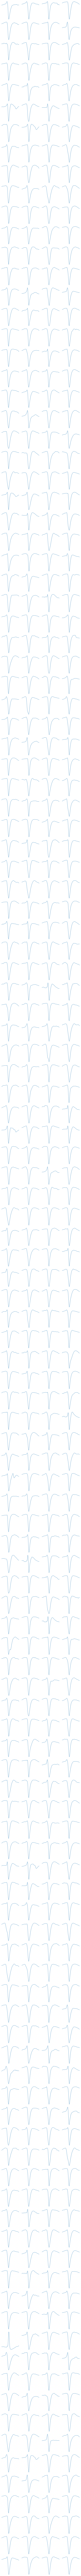

In [35]:
sample = next(iter(train_loader))[0].squeeze(1)[8:]

plot_waveforms_grid(sample)

In [41]:
dec = model.model(next(iter(train_loader))[0][0:8, ...])

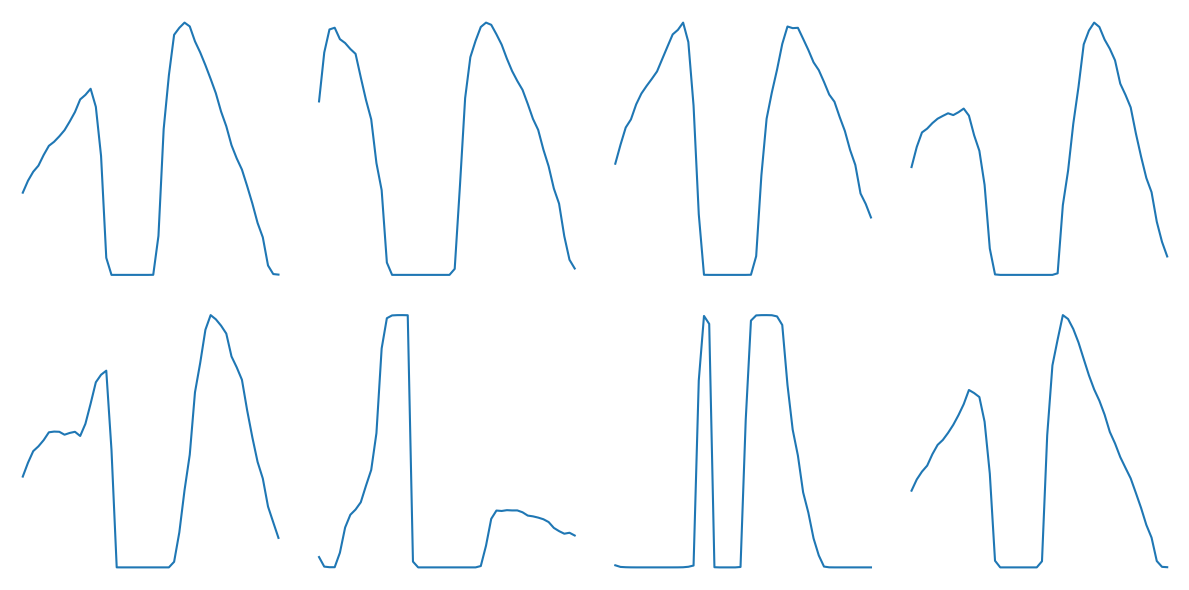

In [45]:
plot_waveforms_grid(dec[-1].squeeze(1).detach())